In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

### 1) Resumen del Proyecto:

### Se tiene un DS con datos de consumo energetico de aparatos electronicos de una vivienda (heladera, lavarropas, hornos, TV, Lavavajillas, etc), junto con mediciones ambientales internas y externas generadas por una red de sensores wireless distribuidos en distintos puntos de la vivienda, lo cual permite visualizar la variacion en el consumo temporalmente y cuales son las variables que mas influyen sobre su variacion.

### En principio se puede ver que los valores mas frecuentes de consumo (independientemente del mes) se mueven entre 40-70 Wh, pero su media es de 97,69 Wh, esto se debe a la dispersion que en algunos casos registra valores dos ordenes de magnitud mayores a la media  (std 102,52 Wh, y valor maximo en 1080 Wh)
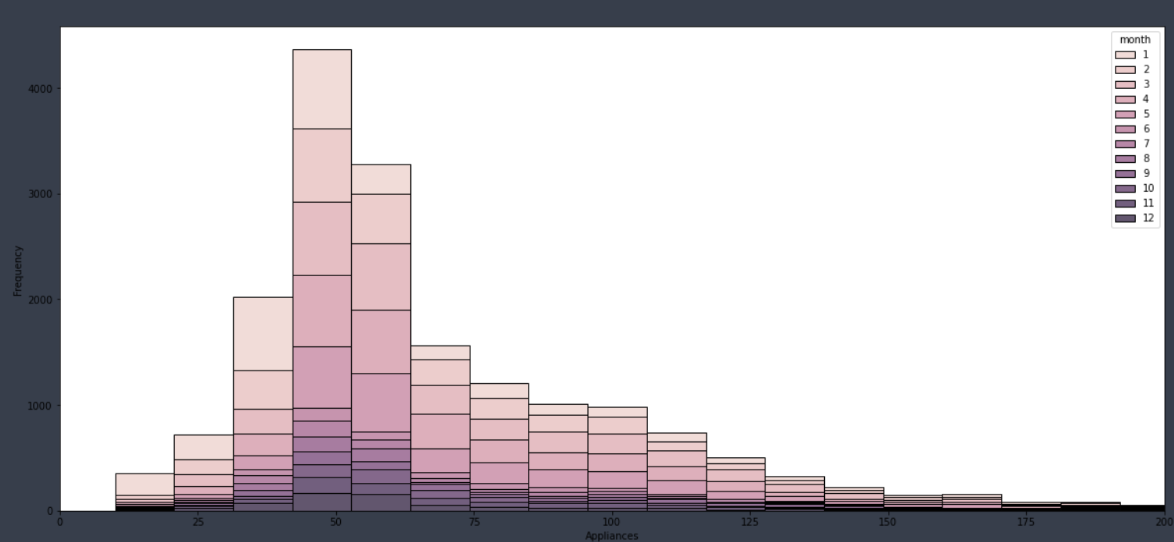
### Se pretende encontrar un modelo de predeccion de consumo lo suficientemente robusto como para ser usado en otro tipo de viviendas o edificios, y que permita definir estrategias para ahorro energetico o uso de energia renovable:
####           -Uso de Energia Solar o similar en los picos de Consumo, o Uso de energia renovable para recarga/almacenamiento en periodos de bajo consumo. 
####           -

#### Algunas ventajas de la prediccion de consumos:
#####       -Las empresas y los individuos pueden convertir la cantidad de energía consumida en valor monetario y por lo tanto, estimar la factura de energía y tomar decisiones basadas en estos datos.
#####       -Práctica: No sólo nos sirve para saber cuánta energía consumimos, sino también para entender cómo y porqué lo hacemos. De esta manera podemos cambiar nuestros hábitos sin afectar nuestra productividad o la calidad de nuestras vidas.
#####       -Técnica: Una mejor gestión de los datos de energía permite la recopilación y el análisis de dichos datos, así como la obtención de predicciones más precisas.


### 2) Lectura y Preparacion del DF

In [2]:
df_energia_hogar = pd.read_csv('C:/Users/javie/Documents/DATA SCIENCE/0. CODERHOUSE - DS/CLASES/Entregables/energydata_complete.csv')
print(df_energia_hogar.head(5))
df_energia_hogar.shape

               date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  11-01-2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  11-01-2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  11-01-2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  11-01-2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  11-01-2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  


(19735, 29)

In [3]:
#date esta en formato string: transformo a datetime
df_energia_hogar['date'] = pd.to_datetime(df_energia_hogar['date'], errors='coerce')
#df_energia_hogar.info()
df_energia_hogar.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [4]:
df_energia_hogar['day'] = pd.to_datetime(df_energia_hogar['date']).dt.date
df_energia_hogar['time'] = pd.to_datetime(df_energia_hogar['date']).dt.time
df_energia_hogar['month'] = pd.to_datetime(df_energia_hogar['date']).dt.month 
#Defino Dias de la Semana: Puede ser util si quiero analizar que sucede los fines de semana y el resto de dias 
df_energia_hogar['day of the week'] = df_energia_hogar.date.dt.day_name()
def set_values(row, value):
    return value[row]
map_dictionary ={'Monday' : "workday", 'Tuesday' :"workday", 'Wednesday' : "workday", 'Thursday' :"workday", 'Friday' : "workday",'Saturday':"weekend",'Sunday':"weekend"} 
df_energia_hogar['Type day'] = df_energia_hogar['day of the week'].apply(set_values, args =(map_dictionary, )) 
df_energia_hogar.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,day,time,month,day of the week,Type day
0,2016-11-01 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,7.000000,63.000000,5.3,13.275433,13.275433,2016-11-01,17:00:00,11,Tuesday,workday
1,2016-11-01 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,6.666667,59.166667,5.2,18.606195,18.606195,2016-11-01,17:10:00,11,Tuesday,workday
2,2016-11-01 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,6.333333,55.333333,5.1,28.642668,28.642668,2016-11-01,17:20:00,11,Tuesday,workday
3,2016-11-01 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,6.000000,51.500000,5.0,45.410390,45.410390,2016-11-01,17:30:00,11,Tuesday,workday
4,2016-11-01 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,5.666667,47.666667,4.9,10.084097,10.084097,2016-11-01,17:40:00,11,Tuesday,workday


In [5]:
df_energia_hogar_workday = df_energia_hogar[df_energia_hogar['Type day'] != 'weekend'] 
df_energia_hogar_weekend = df_energia_hogar[df_energia_hogar['Type day'] != 'workday']


### Describo brevemente la variable de interes ('Appliances') como linea de base:

In [6]:
df_energia_hogar['Appliances'].describe()

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64

In [7]:
df_energia_hogar['date'].describe()

<ipython-input-7-f62c0c9bf227>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_energia_hogar['date'].describe()


count                   19735
unique                  19735
top       2016-11-01 17:00:00
freq                        1
first     2016-01-02 00:00:00
last      2016-12-05 23:50:00
Name: date, dtype: object

(735976.0, 735982.0)

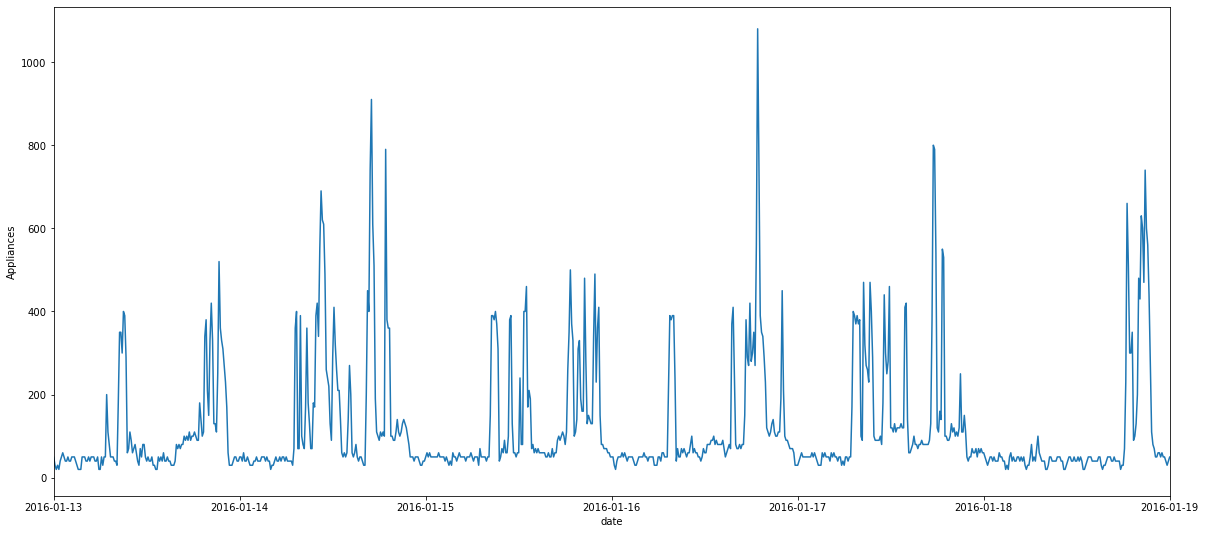

In [8]:
# Como es la variabilidad de los consumos en funcion del tiempo?
import datetime
fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.lineplot(data=df_energia_hogar, x="date", y="Appliances")
ax.set_xlim([datetime.date(2016,1, 13), datetime.date(2016, 1, 19)]) # 1º semana (la primera del año)



(735981.0, 735982.0)

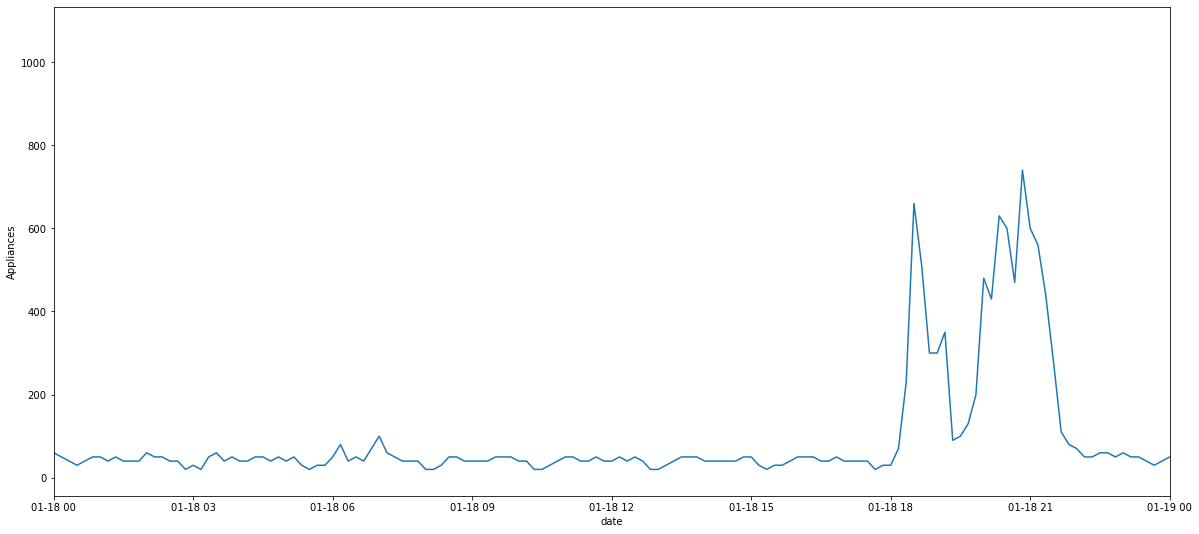

In [9]:
# Como es la variabilidad de los consumos en funcion del tiempo?
import datetime
fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.lineplot(data=df_energia_hogar, x="date", y="Appliances")
ax.set_xlim([datetime.date(2016,1, 18), datetime.date(2016, 1, 19)]) # en un dia
# se ve incremento en consumo a partir de las 18 hs

### No hay variaciones significativas en la semana. Si bien, hay picos que bastante dispersos respecto a la media de consumo ocurren en periodos bastante acotados. En la semana se ven mesetas y valles, que pueden sugerir consumos altos por la noche y un consumo de base por la mañana-tarde donde debe haber menor presencia de personas en el hogar. 

(0.0, 200.0)

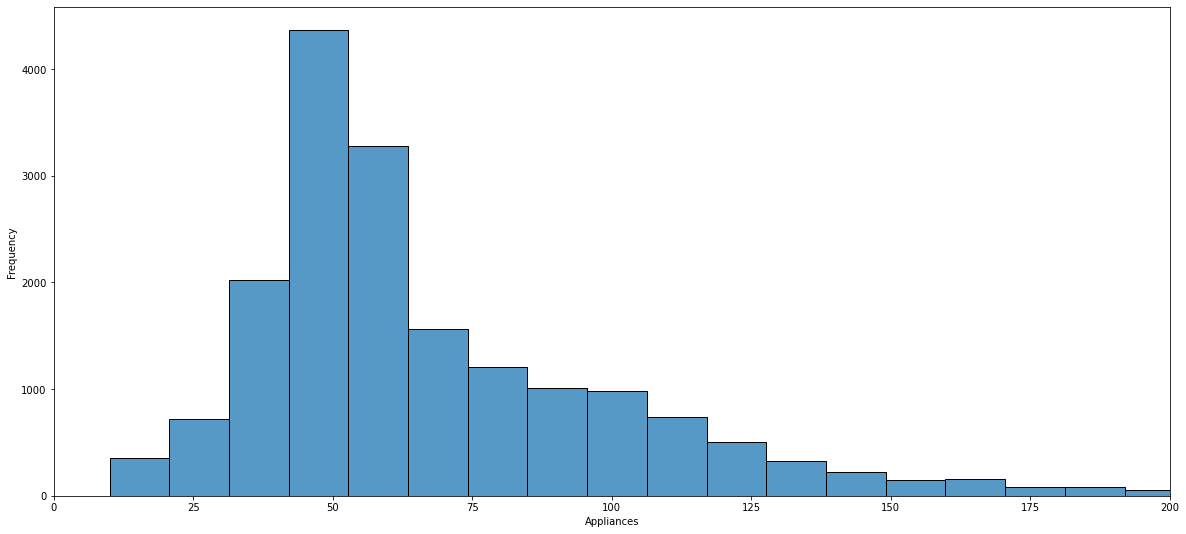

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.histplot(data=df_energia_hogar, x="Appliances", bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('Appliances')
plt.xlim(0, 200)


(0.0, 200.0)

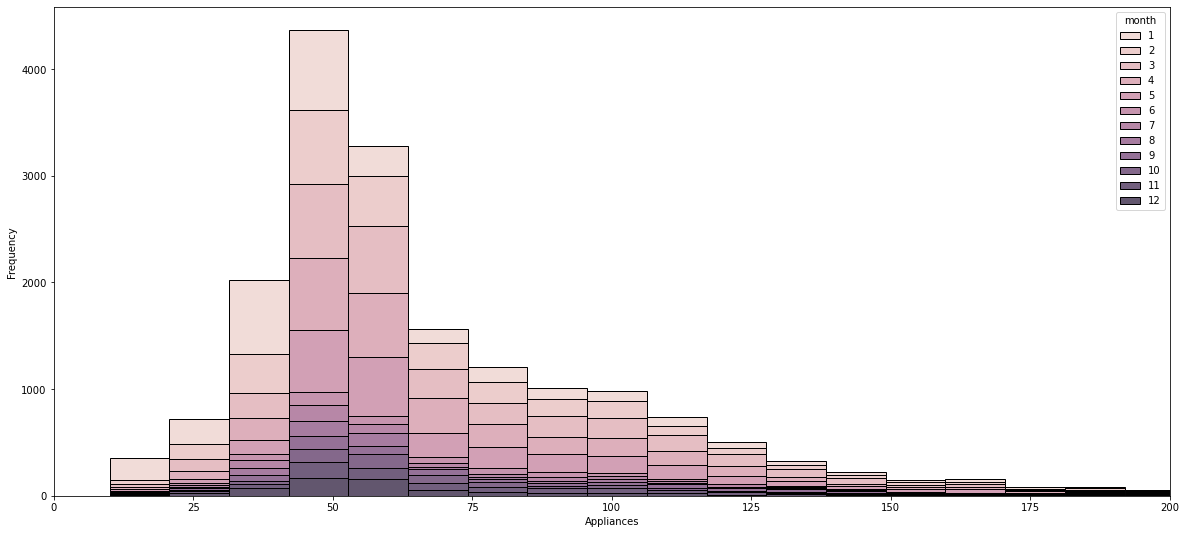

In [11]:
# Histogramas solapados categorizando por mes
fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.histplot(data=df_energia_hogar, x="Appliances", hue="month", multiple="stack",bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('Appliances')
plt.xlim(0, 200)


(0.0, 200.0)

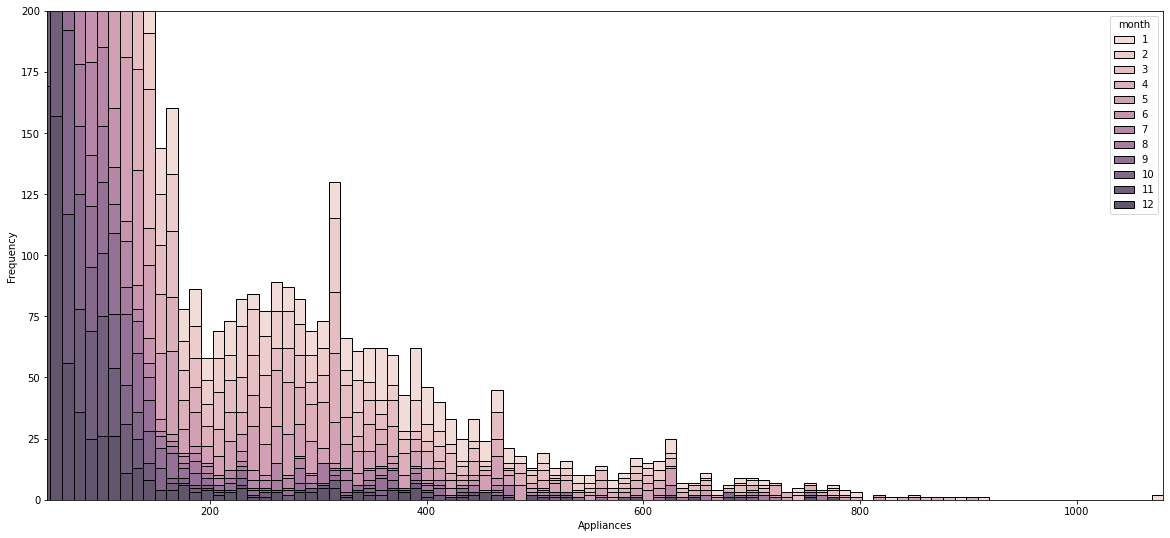

In [12]:
# Que patrones se pueden observar en los extremos de histograma?:

fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.histplot(data=df_energia_hogar, x="Appliances", hue="month", multiple="stack",bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('Appliances')
plt.xlim(50, 1080)
plt.ylim(0, 200)


(0.0, 200.0)

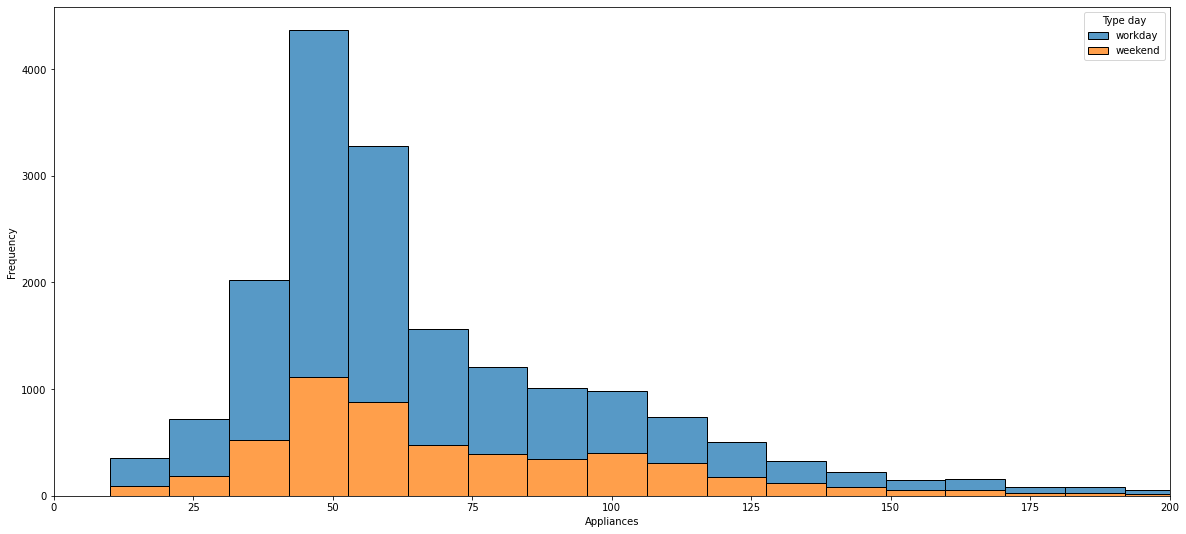

In [13]:
# HISTOGRAMA PARA LOS FINES DE SEMANA

fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.histplot(data=df_energia_hogar, x="Appliances", hue="Type day", multiple="stack",bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('Appliances')
plt.xlim(0, 200)



In [14]:
df_energia_hogar_workday['Appliances'].describe()


count    13831.000000
mean        94.733570
std        100.830748
min         10.000000
25%         50.000000
50%         60.000000
75%         90.000000
max       1070.000000
Name: Appliances, dtype: float64

In [15]:
df_energia_hogar_weekend['Appliances'].describe()


count    5904.000000
mean      104.632453
std       106.073565
min        10.000000
25%        50.000000
50%        70.000000
75%       110.000000
max      1080.000000
Name: Appliances, dtype: float64

### No hay variacion significativa los fines de semana respecto a los dias laborables. En terminos de la media existe un consumo levemente mas alto los fines de semana (10 Wh mas), que puede deberse a una permanencia mayor en la vivienda respecto a los dias laborables. 

Text(0.5, 1.0, 'Appliances vs month')

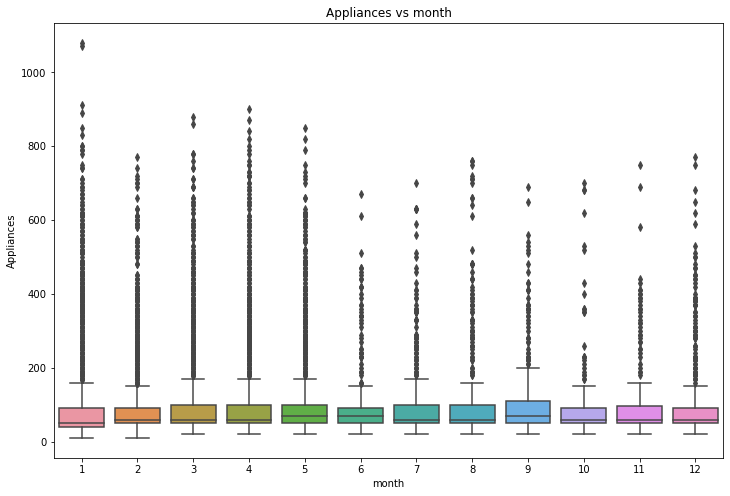

In [16]:
# Boxplot respecto a los meses del año
fig, ax = plt.subplots()
fig.set_size_inches((12,8))
sns.boxplot(x='month',y='Appliances',data=df_energia_hogar,ax=ax)
ax.set_ylabel('Appliances')
ax.set_xlabel('month')
ax.set_title('Appliances vs month')


<ipython-input-17-bd0074a97748>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_energia_hogar.corr(), cmap='Blues')


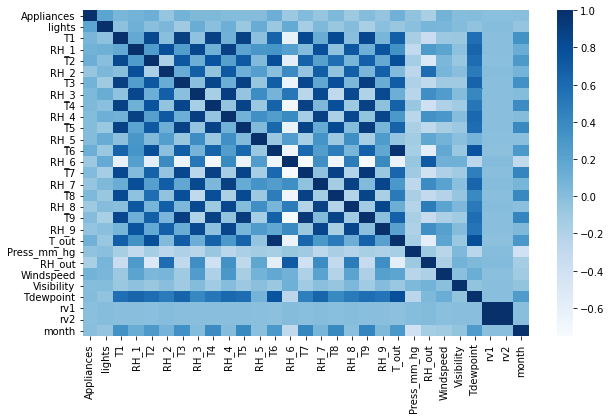

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(data=df_energia_hogar.corr(), cmap='Blues')

In [18]:
df_energia_hogar.corr()

<ipython-input-18-7f786b292621>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_energia_hogar.corr()


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,month
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015357,-0.011145,-0.011145,-0.006745
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,-0.008766,-0.074423,-0.010576,0.068543,0.060281,0.020038,-0.036331,0.000521,0.000521,-0.050865
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,0.071756,0.682854,-0.150574,-0.345481,-0.087654,-0.076210,0.571333,-0.006203,-0.006203,0.335936
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,0.764001,0.340788,-0.293957,0.274126,0.204932,-0.021057,0.639125,-0.000699,-0.000699,0.134118
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.157346,0.792247,-0.133028,-0.505291,0.052495,-0.069721,0.582632,-0.011087,-0.011087,0.286658
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,0.676467,0.033703,-0.255646,0.584911,0.069190,-0.005368,0.499154,0.006275,0.006275,0.075489
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.134602,0.699420,-0.189974,-0.281718,-0.100776,-0.102310,0.645909,-0.005194,-0.005194,0.346614
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,0.833538,0.118237,-0.233274,0.356192,0.263188,0.017041,0.414398,-0.000477,-0.000477,0.016185
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,-0.025549,0.663479,-0.075292,-0.388602,-0.185747,-0.104768,0.519504,-0.001815,-0.001815,0.382177
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,0.856591,0.293307,-0.250748,0.336813,0.300192,0.002636,0.616508,-0.001787,-0.001787,0.008766


In [19]:
df_correlaciones = df_energia_hogar.drop(columns=['date', 'rv1', 'rv2', 'day', 'time', 'month', 'day of the week', 'Type day'])

In [20]:

def parejas(df_correlaciones):
    '''Obtiene diagonal inferior de parejas en matriz de correlacion'''
    pairs_to_drop = set()
    cols = df_correlaciones.columns
    for i in range(0, df_correlaciones.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def correlaciones(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = parejas(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Correlaciones mas grandes")
print(correlaciones(df_correlaciones, 25)) # Saquemos el top 10

Correlaciones mas grandes
T6    T_out    0.974778
T7    T9       0.944776
T5    T9       0.911055
T3    T9       0.901324
RH_3  RH_4     0.898978
RH_4  RH_7     0.894301
T1    T3       0.892402
T4    T9       0.889439
T3    T5       0.888169
T1    T5       0.885247
RH_7  RH_8     0.883984
T7    T8       0.882123
RH_1  RH_4     0.880359
T4    T7       0.877763
T1    T4       0.877001
T4    T5       0.871813
T5    T7       0.870624
T8    T9       0.869338
RH_7  RH_9     0.858686
RH_4  RH_9     0.856591
RH_8  RH_9     0.855812
T3    T4       0.852778
      T7       0.847374
RH_4  RH_8     0.847259
T1    T9       0.844777
dtype: float64


# Preguntas de interes:

**1) Existen correlaciones posivas entre el consumo y el resto de variables?**
Hay correlaciones positivas entre Appliances y:   
            -Lights (+0.19)  
            -T2 (+0.12)  
            -T6 (+0.12)  
            -T_out(+0.1)  
            -Windspeed (+0.09)  
            
**2) Existe variaciones estacionales significativas?:**
            No se han observado variaciones significativas, dado que tanto en los boxplot   
            mensuales como en los histogramas el pico se mantiene en el mismo rango de   
            valores.  
            Por otro lado, se realizó una segmentacion de datos de acuerdo al tipo de dia de  
            la semana. Tampoco se han percibido variaciones significativas entre dias laborables  
            y fines de semana.  
            
**3) Existe variaciones horarias significativas?:**  
            Si se toma el lineplot horario (considerando solo un dia), se ve que el consumo se mantiene en estable y en su  minimo a lo largo de la mañana y tarde, hasta las 18 hs donde comienza a incrementarse significativamente.
 
         
  


# Glosario de variables:

Appliances: energy use in Wh of appliances (variable target) 'Consumo de Aparatos Electronicos'   

lights: energy use of light fixtures in the house in Wh    

T1: Temperature in kitchen area, in Celsius  

RH_1:Humidity in kitchen area, in %  

T2:Temperature in living room area, in Celsius  

RH_2: Humidity in living room area, in %  

T3: Temperature in laundry room area  

RH_3: Humidity in laundry room area, in %  

T4: Temperature in office room, in Celsius  

RH_4: Humidity in office room, in %  

T5: Temperature in bathroom, in Celsius  

RH_5: Humidity in bathroom, in %  

T6: Temperature outside the building (north side), in Celsius  

RH_6: Humidity outside the building (north side), in %  

T7: Temperature in ironing room , in Celsius  

RH_7: Humidity in ironing room, in %  

T8:  Temperature in teenager room 2, in Celsius  

RH_8:  Humidity in teenager room 2, in %  

T9:  Temperature in parents room, in Celsius    

RH_9: Humidity in parents room, in %   

T_out: Temperature outside (from Chievres weather station), in Celsius  

Press_mm_hg: Pressure (from Chievres weather station), in mm Hg  

RH_out: Humidity outside (from Chievres weather station), in %  

Windspeed: Wind speed (from Chievres weather station), in m/s  

Visibility: Visibility (from Chievres weather station), in km  

Tdewpoint: Tdewpoint (from Chievres weather station), Â°C  

rv1: Random variable 1, nondimensional  

rv2: Random variable 2, nondimensional  

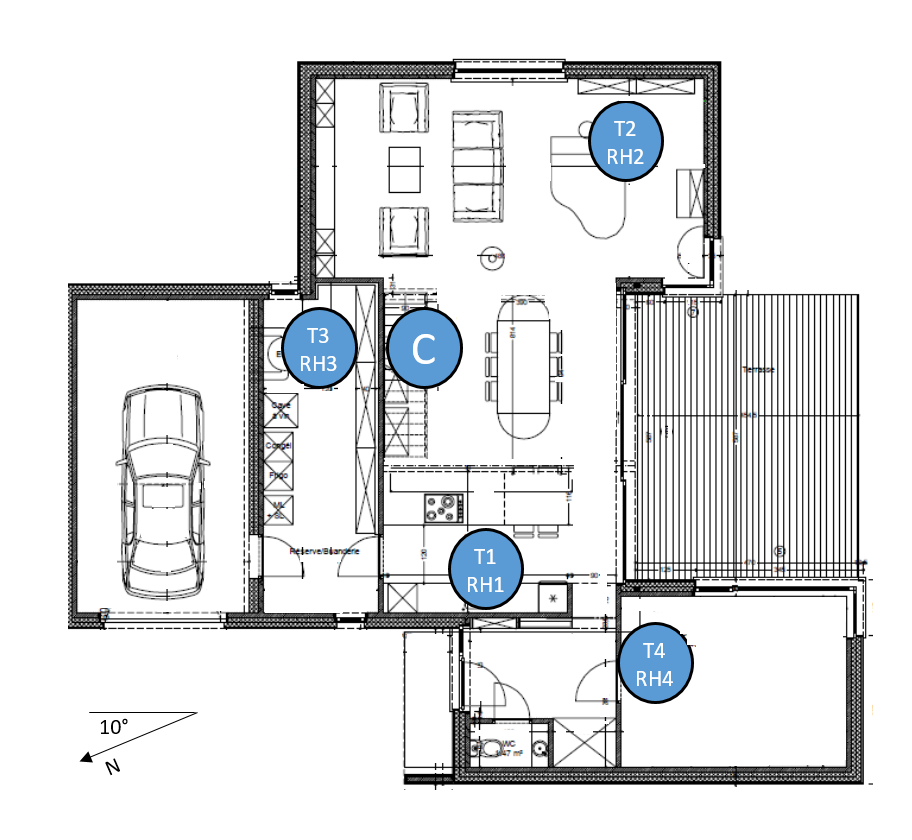
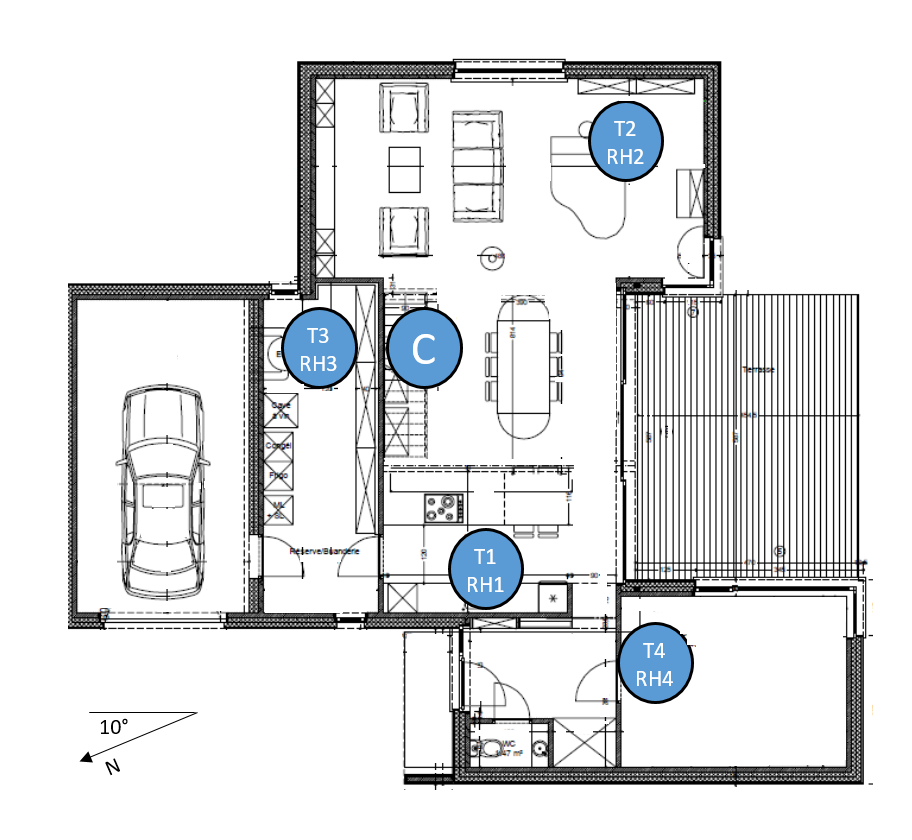


# FUNCIONES AUXILIARES:
PROFILER PARA EL DS:
prof = ProfileReport(df_energia_hogar)
prof.to_file(output_file='df_energia.html')

TEMPERATURAS SEGUN MES PARA CONOCER LA ESTACIONALIDAD DE LA REGION:
df_T_out_max = df_energia_hogar.groupby('month')['T_out'].max().reset_index()
df_T_out_mean = df_energia_hogar.groupby('month')['T_out'].mean().reset_index()
df_T_out_min = df_energia_hogar.groupby('month')['T_out'].min().reset_index()
df_T_out = pd.concat([df_T_out_max, df_T_out_mean['T_out'], df_T_out_min['T_out']], axis=1)
df_T_out.set_axis(['month','T_out_max', 'T_out_mean', 'T_out_min'], axis='columns', inplace=True)
df_T_out






